In [124]:
using Pkg
using BenchmarkTools 
using Catalyst
using TreeView

### What is metaprogramming?

The word "meta" roughly means "something on a higher level". So metaprogramming means "higher-level programming": writing code (a program) that manipulates code (and the new code will then manipulate data).

Ex:

In [87]:
my_long_variable = 3 
println("my_long_variable= $my_long_variable")

my_long_variable= 3


look that we written "my_long_variable" twice, this is not a good practice acoording to DRY (don't repeat Yourself)

In [88]:
function myshow(x)
    println("the value is $x")
end

myshow (generic function with 1 method)

In [89]:
a = 1
b = 2

2

In [90]:
myshow(a + b)


the value is 3


But if we want to know whose value is that, the function dows not know - it receives only the value itself.

The solution is to use a **macro**; macros are indicated with the @ symbol

In [91]:
@show a + b

a + b = 3


3

macro take a piece of code, manipulate it in some way and spit out a new piece of code, and that peace of code is what julia will run. This processing is called **Code generation**.

In [92]:
@macroexpand @show x

quote
    Base.println("x = ", Base.repr(begin
                #= show.jl:1047 =#
                local var"#152#value" = x
            end))
    var"#152#value"
end

In [93]:
Base.remove_linenums!(@macroexpand @show x)

quote
    Base.println("x = ", Base.repr(begin
                local var"#153#value" = x
            end))
    var"#153#value"
end

In [94]:
@time exp(1)

  0.000001 seconds


2.718281828459045

In [95]:
@btime exp(1)

  1.479 ns (0 allocations: 0 bytes)


2.718281828459045

In [96]:
Base.remove_linenums!(@macroexpand @time exp(1))

quote
    begin
        $(Expr(:meta, :force_compile))
        local var"#162#stats" = Base.gc_num()
        local var"#164#elapsedtime" = Base.time_ns()
        Base.cumulative_compile_timing(true)
        local var"#165#compile_elapsedtimes" = Base.cumulative_compile_time_ns()
        local var"#163#val" = $(Expr(:tryfinally, :(exp(1)), quote
    var"#164#elapsedtime" = Base.time_ns() - var"#164#elapsedtime"
    Base.cumulative_compile_timing(false)
    var"#165#compile_elapsedtimes" = Base.cumulative_compile_time_ns() .- var"#165#compile_elapsedtimes"
end))
        local var"#166#diff" = Base.GC_Diff(Base.gc_num(), var"#162#stats")
        local var"#167#_msg" = Base.nothing
        local var"#168#has_msg" = !(Base.isnothing(var"#167#_msg"))
        var"#168#has_msg" && Base.print(var"#167#_msg", ": ")
        Base.time_print(var"#164#elapsedtime", (var"#166#diff").allocd, (var"#166#diff").total_time, Base.gc_alloc_count(var"#166#diff"), Base.first(var"#165#compile_elapsedtimes"), B

In [97]:
function f(x, y, ⊕)
    return x ⊕ y 
end

# ⊕(x,y)

f (generic function with 1 method)

In [98]:
f(3, 4, +)

7

In [99]:
f(3, 4, *)

12

In [100]:
f(3, 4, max)

4

(3 + 4) is the same than +(3, 4)

The Meta.parse convert an appropriate string to an expression

In [73]:
code = Meta.parse("j = i^2")

:(j = i ^ 2)

In [77]:
dump(code.args[2])

Expr
  head: Symbol call
  args: Array{Any}(

(3,))
    1: Symbol ^
    2: Symbol i
    3: Int64 2


In [81]:
code.head

:(=)

In [80]:
code.args

2-element Vector{Any}:
 :j
 :(i ^ 2)

the "+" is an object, a function that has 190 methods by default. The ":+" refer to an unevaluated piece of code  

In [104]:
# I'm making s a symbol.
s = :+

:+

In [102]:
Symbol("x")

:x

In [105]:
typeof(s)

Symbol

In [106]:
ex = :(x+y)

:(x + y)

This is an unevaluated piece of code 

In [107]:
typeof(ex)

Expr

In [109]:
dump(ex)

Expr
  head: Symbol call
  args: Array{Any}((3,))
    1: Symbol +
    2: Symbol x
    3: Symbol y


In [111]:
ex.head

:call

:(x+y) == :(+(x,y))

In [114]:
Meta.show_sexpr(:(x+y))

(:call, :+, :x, :y)

We can create a expr

In [115]:
Expr(:call, :+, :x, :y)

:(x + y)

In [116]:
ex =:(x+y*z)

:(x + y * z)

In [139]:
dump(ex)

Expr

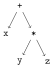

In [125]:
@tree x + y * z

In [126]:
ex = quote
    x = x + 1 
    y = y + x
end

quote
    #= /home/mack/Code/Julia/metaprogramming/metaprogramming.ipynb:2 =#
    x = x + 1
    #= /home/mack/Code/Julia/metaprogramming/metaprogramming.ipynb:3 =#
    y = y + x
end

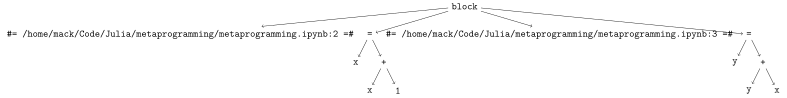

In [134]:
TreeView.walk_tree(ex)

We can construct an expression usin the **quote** too

In [141]:
ex = quote
    1+1
end

quote
    #= /home/mack/Code/Julia/metaprogramming/metaprogramming.ipynb:2 =#
    1 + 1
end

In [142]:
typeof(ex)

Expr

In [144]:
dump(ex)

Expr
  head: Symbol block
  args: Array{Any}((2,))
    1: LineNumberNode
      line: Int64 2
      file: Symbol /home/mack/Code/Julia/metaprogramming/metaprogramming.ipynb
    2: Expr
      head: Symbol call
      args: Array{Any}((3,))
        1: Symbol +
        2: Int64 1
        3: Int64 1


Getting the value of the expression

In [145]:
eval(ex)

2

**struct** is one of the most commonly type in julia because it allows us to define other custom types similar to classes in an object-oriented programming language 

In [146]:
struct MyObj
    field1
    field2 
end

now we can create an object using this struct

In [147]:
myobj1 = MyObj("Hello", "World")

MyObj("Hello", "World")

In [148]:
myobj1.field1

"Hello"

In [149]:
myobj1.field1 = "test"

ErrorException: setfield!: immutable struct of type MyObj cannot be changed

the structure is immutable by default

In [153]:
mutable struct Person
    name::String 
    age::Int64
end

In [154]:
allison = Person("Allison", 24)

Person("Allison", 24)

In [155]:
allison

Person("Allison", 24)

In [156]:
allison.age = 25

25

In [157]:
allison

Person("Allison", 25)

In [159]:
function birthday(person::Person)
    person.age += 1 
end

birthday (generic function with 1 method)

In [160]:
birthday(allison)

26

In [161]:
allison

Person("Allison", 26)

In [177]:
ex = quote
    x = x + 1
    y = y + x 
end

quote
    #= /home/mack/Code/Julia/metaprogramming/metaprogramming.ipynb:2 =#
    x = x + 1
    #= /home/mack/Code/Julia/metaprogramming/metaprogramming.ipynb:3 =#
    y = y + x
end

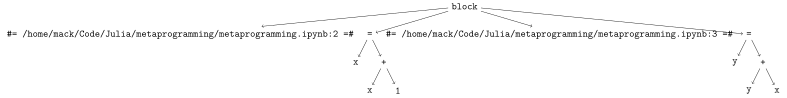

In [178]:
TreeView.walk_tree(ex)

In [179]:
ex.head

:block

In [180]:
ex.args

4-element Vector{Any}:
 :(#= /home/mack/Code/Julia/metaprogramming/metaprogramming.ipynb:2 =#)
 :(x = x + 1)
 :(#= /home/mack/Code/Julia/metaprogramming/metaprogramming.ipynb:3 =#)
 :(y = y + x)

In [186]:
function substitute(ex)
    for i in 1:length(ex.args)
        if ex.args[i] == :x 
            ex.args[i] = :y
        end 
    end 
    return ex
end

substitute (generic function with 1 method)

In [187]:
ex = :(x + x *y)

:(x + x * y)

In [188]:
substitute!(ex)

:(y + x * y)

In [191]:
function substitute!(ex)
    for i in 1:length(ex.args)
        if ex.args[i] == :x 
            ex.args[i] = :y

        elseif ex.args[i] isa Expr          # if typeof(ex.args[i]) === Expr
            substitute!(ex.args[i])
        end 
    end 
    return ex
end

substitute! (generic function with 1 method)

In [192]:
ex = :(x + x * y)

:(x + x * y)

In [194]:
substitute!(ex)

:(y + y * y)

A **macro** take a piece of code replace it with a piece of code and then compile that new piece of code 

In [195]:
macro simple(ex)
    @show ex 
    @show typeof(ex)

    return nothing
end

@simple (macro with 1 method)

In [197]:
@simple a = b

ex = :(a = b)
typeof(ex) = Expr
